In [1]:
import json
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import mplhep as mh

from hist.hist import Hist
from hist.axis import Regular
from hist.axis import IntCategory
from hist.axis import StrCategory

from pathlib import Path

from typing import Optional, Union

from matplotlib.colors import Colormap, ListedColormap
from matplotlib.colors import LogNorm

from hist import intervals

In [2]:
from functools import cache
from functools import cached_property

@cache
def get_segment(ring: int, station: int, sector: int, subsector: int) -> int:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L361-L368
    """
    nsub = 3 if ring == 1 and station > 1 else 6
    return subsector + nsub * (sector - 1)


@cache
def get_roll_name(region: int, ring: int, station: int, sector: int, layer: int,
             subsector: int, roll: int
) -> str:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L11-L87
    """
    if region == 0:
        name = f'W{ring:+d}_RB{station}'

        if station <= 2:
            name += 'in' if layer == 1 else 'out'
        else:
            if sector == 4 and station == 4:
                name += ['--', '-', '+', '++'][subsector - 1]
            elif (station == 3) or (station == 4 and sector not in (4, 9, 11)):
                name += '-' if subsector == 1 else '+'
        name += f'_S{sector:0>2d}_'
        name += ['Backward', 'Middle', 'Forward'][roll - 1]
    else:
        segment = get_segment(ring, station, sector, subsector)
        name = f'RE{station * region:+d}_R{ring}_CH{segment:0>2d}_'
        name += ['A', 'B', 'C', 'D', 'E'][roll - 1]
    return name

In [3]:
def load_data(
    input_path: Path,
    columns: list,
    roll_blacklist_path: Optional[Path] = None,
) -> dict:
    #############################################################
    ##     COLUMNS
    ##     'is_fiducial', 'is_matched', 
    ##     'region', 'ring', 'station', 'sector', 'layer', 'subsector', 'roll', 
    ##     'run', 'cls', 'bx', 'event',
    ##     'tag_pt', 'tag_eta', 'tag_phi', 
    ##     'probe_pt', 'probe_eta', 'probe_phi', 'probe_time', 'probe_dxdz', 'probe_dydz', 
    ##     'dimuon_pt', 'dimuon_mass', 
    ##     'residual_x', 'residual_y', 'pull_x', 'pull_y', 'pull_x_v2', 'pull_y_v2', 
    #############################################################
    data = uproot.open(f"{str(input_path)}:tree").arrays(columns, library='np')
    
    fiducial_mask = data['is_fiducial']
    for key, values in data.items():
        data[key] = data[key][fiducial_mask]

    data['roll_name'] = np.array([
        get_roll_name(
            data['region'][idx], data['ring'][idx], data['station'][idx],
            data['sector'][idx], data['layer'][idx], data['subsector'][idx], data['roll'][idx]
        ) for idx in range(len(data['region']))
    ])

    if roll_blacklist_path is None:
        roll_blacklist = set()
    else:
        with open(roll_blacklist_path) as stream:
            roll_blacklist = set(json.load(stream))
    
    is_blacklist = np.vectorize(lambda item: item in roll_blacklist)
    blacklist_mask = is_blacklist(data['roll_name'])

    for key, values in data.items():
        data[key] = data[key][~blacklist_mask]

    return data

def load_region_data(
    input_data: dict,
    region: str
):
    if region == "all":
        is_region = np.vectorize(lambda item: type(item) is str)
    elif region == "barrel":
        is_region = np.vectorize(lambda item: item.startswith('W'))
    elif region == "disk123":
        is_region = np.vectorize(lambda item: item.startswith(('RE+1', 'RE+2', 'RE+3', 'RE-1', 'RE-2', 'RE-3')))
    elif region == "disk4":
        is_region = np.vectorize(lambda item: item.startswith(('RE+4', 'RE-4')))
    else:
        is_region = np.vectorize(lambda item: item.startswith(region))

    region_mask = is_region(data['roll_name'])

    region_data = {}
    for key, values in data.items():
        region_data[key] = data[key][region_mask]

    return region_data

In [15]:
def plot_eff_run(
    data: dict,
    ax: Optional[plt.Axes] = None,
    region: str = 'All',
    data_legend: str = "All",
    errorbar_color = 'black'
):
    region_data = load_region_data(input_data=data, region=region)

    runs = np.unique(region_data['run'])
    run_effs = []
    run_eff_err_lowers = []
    run_eff_err_uppers = []

    for run in runs:
        run_is_matched = region_data['is_matched'][region_data['run'] == run]
        run_total = len(run_is_matched)
        run_passed = len(run_is_matched[run_is_matched])
        run_eff = run_passed / run_total * 100
        run_eff_err = intervals.clopper_pearson_interval(run_passed, run_total, 0.954) * 100
        run_eff_err_lowers.append(run_eff - run_eff_err[0])
        run_eff_err_uppers.append(run_eff_err[1] - run_eff)
        run_effs.append(run_eff)

    run_effs = np.array(run_effs)
    
    #print(runs)
    #print(len(runs))
    #print(run_effs)
    #print(len(run_effs))
    #print(run_eff_err_lowers)
    #print(len(run_eff_err_lowers))
    #print(run_eff_err_uppers)
    #print(len(run_eff_err_uppers))

    ax.errorbar(
        runs, run_effs,
        yerr = (run_eff_err_lowers, run_eff_err_uppers),
        fmt = '.',
        capsize = 2,
        c = errorbar_color,
        label=data_legend,
    )
    return ax

In [5]:
working_dir = Path('/users/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/TnP_Plotting')

columns = [
    'is_fiducial', 'is_matched', 
    'region', 'ring', 'station', 'sector', 'layer', 'subsector', 'roll', 
    'run', 'cls', 'bx', 'event',
]

data = load_data(
    input_path = working_dir / 'data' / 'Run3.root',
    #input_path = working_dir / 'data' / 'SingleMuon__Run2022C.root',
    roll_blacklist_path = working_dir / 'blacklist' / 'roll-blacklist.json',
    columns = columns
)


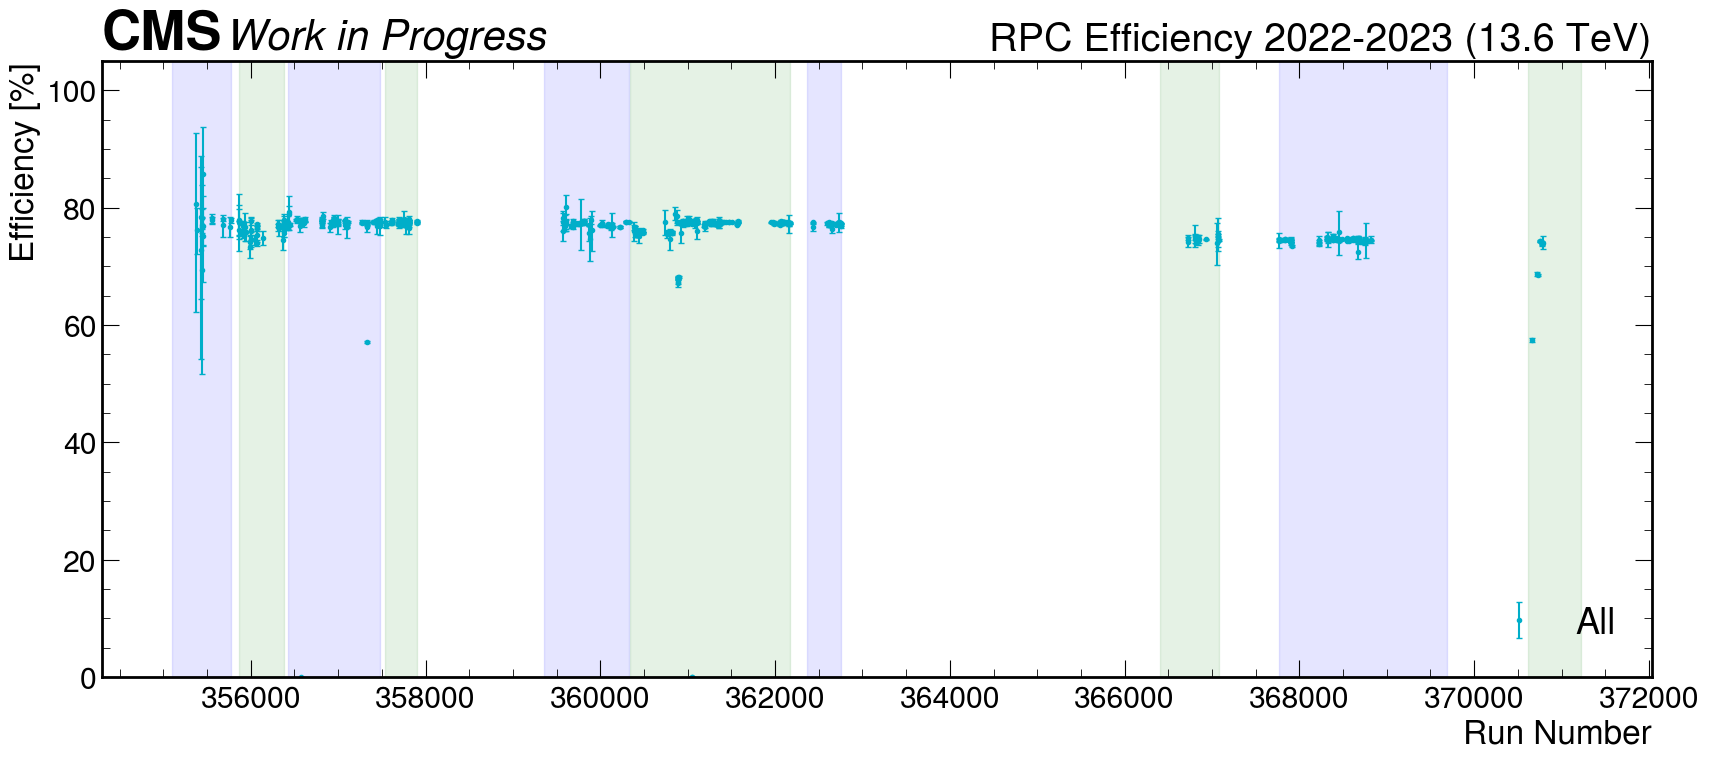

In [18]:
mh.style.use(mh.styles.CMS)
fig, ax = plt.subplots(figsize=(20, 8))

label = "Work in Progress"
com = 13.6

mh.cms.label(ax=ax, data=True, label=label, com=com, year="RPC Efficiency 2022-2023", fontsize=30)
ax.set_xlabel('Run Number', fontsize=24)
ax.set_ylabel('Efficiency [%]', fontsize=24)
ax.set_ylim(0, 105)


#ax = plot_eff_run(
#    data = data,
#    ax = ax,
#    region = 'all',
#    data_legend = 'All',
#    errorbar_color = '#00AEC9',
#)

ax = plot_eff_run(
    data = data,
    ax = ax,
    region = 'barrel',
    data_legend = 'Barrel',
    errorbar_color = '#21bf70',
)

ax = plot_eff_run(
    data = data,
    ax = ax,
    region = 'RE',
    data_legend = 'Endcap',
    errorbar_color = '#0714FF',
)


ax.axvspan(355100, 355769, color='b', alpha=0.1)
ax.axvspan(355862, 356386, color='g', alpha=0.1)
ax.axvspan(356426, 357482, color='b', alpha=0.1)
ax.axvspan(357538, 357900, color='g', alpha=0.1)
ax.axvspan(359356, 360327, color='b', alpha=0.1)
ax.axvspan(360335, 362167, color='g', alpha=0.1)
ax.axvspan(362362, 362760, color='b', alpha=0.1)

ax.axvspan(366403, 367079, color='g', alpha=0.1)
ax.axvspan(367770, 369694, color='b', alpha=0.1)
ax.axvspan(370616, 371225, color='g', alpha=0.1)





ax.legend(fontsize="26", loc='lower right')

output_dir = working_dir / 'plotting' / 'EffByRun'

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / f"Run3Efficiency.png")

In [ ]:
ax = plot_eff_run(
    data = data,
    ax = ax,
    region = 'barrel',
    data_legend = 'Barrel',
    errorbar_color = '#21bf70',
)

ax = plot_eff_run(
    data = data,
    ax = ax,
    region = 'disk123',
    data_legend = 'Endcap (without Disk 4)',
    errorbar_color = '#0714FF',
)


ax = plot_eff_run(
    data = data,
    ax = ax,
    region = 'disk4',
    data_legend = 'Disk 4',
    errorbar_color = 'red',
)